In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
%matplotlib inline

Let's define and visualize the graph

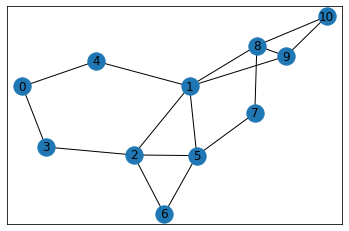

In [3]:
edges = [(0,4),(4,0),(0,3),(3,0),(1,2),(2,1),(1,4),(4,1),(1,8),(8,1),(1,9),(9,1),
        (2,3),(3,2),(2,6),(6,2),(1,5),(5,1),(2,5),(5,2),(5,6),(6,5),(7,8),(8,7),(7,5),(5,7),
        (8,9),(9,8),(8,10),(10,8),(9,10),(10,9)]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

Here I initialize Reward and Q matrix:

In [4]:
R = np.matrix(np.zeros(shape=(11,11)))
for x in G[10]:
    R[x,10]=100

In [6]:
Q = np.matrix(np.zeros(shape=(11,11)))
Q-= 100
for node in G.nodes:
    for x in G[node]:
        Q[node,x]=0
        Q[x,node]=0

10.düğüme gelen actionslar hariç tüm rewards leri 0 olarak ayarlıyoruz. Bu actionslar 8'den 10'a veya 9'dan 10'a gidiyor. Rewards gibi, Q-value bir matriste başlatılıyor. Impossbile actionsları ortadan kaldırmak için Q değerleri -100 olarak ayarlanmıştır. Örneğin, grafikte 2'den 10'a doğrudan gitmek mümkün değildir, bu nedenle Q değerleri -100 olarak ayarlanmıştır. Olası eylemler 0 olarak başlatılıyor. R ve Q matrislerine bir göz atacak olursak: 


In [7]:
import pandas as pd
pd.DataFrame(R)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [8]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10
0,-100.0,-100.0,-100.0,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,0.0,-100.0,0.0,0.0,-100.0,-100.0,0.0,0.0,-100.0
2,-100.0,0.0,-100.0,0.0,-100.0,0.0,0.0,-100.0,-100.0,-100.0,-100.0
3,0.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
5,-100.0,0.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,-100.0,-100.0,-100.0
6,-100.0,-100.0,0.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0
7,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,0.0,-100.0,-100.0
8,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,0.0,0.0
9,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,0.0


Şimdi de bir başlangıç düğümünü alan ve sonraki düğümü döndüren bir işlev tanımlayalım. Ayrıca rastgele keşif için keşif oranını da kabul eder. Aksi takdirde, olası eylemlerin en yüksek Q değerine göre eylemi seçer.


In [9]:
def next_number(start,er):
    random_value = random.uniform(0,1)
    if random_value < er:
        sample = G[start]
    else:
        sample=np.where(Q[start,]==np.max(Q[start,]))[1]
    next_node = int(np.random.choice(sample,1))
    return next_node

Daha sonra, alınan eylemin Q değerini güncellemek için bir işleve ihtiyacımız var.

In [10]:
def updateQ(node1,node2,lr,discount):
    max_index = np.where(Q[node2,]== np.max(Q[node2,]))[1] # find the index of the highest Q-valuee
    if max_index.shape[0] >1:
        max_index = int(np.random.choice(max_index,size=1))
    else:
        max_index = int(max_index)
    max_value= Q[node2,max_index]
    Q[node1,node2] = int((1-lr)*Q[node1,node2]+lr*(R[node1,node2]+discount*max_value))  #updates the Q-value


Şimdi rastgele düğümlerden başlayıp 50000 yürüyüş yaparak Q değerlerini iyileştirmeye çalışıyoruz

In [11]:
def learn(er,lr,discount):
    for i in range(50000):
        start = np.random.randint(0,11)
        next_node=next_number(start,er)
        updateQ(start,next_node,lr,discount)
        
learn(0.5,0.8,0.8) #I set exploration rate, learning rate and discount factor of the learning

Lets check the final Q-values

In [12]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10
0,-100.0,-100.0,-100.0,110.0,138.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,138.0,-100.0,138.0,138.0,-100.0,-100.0,218.0,218.0,-100.0
2,-100.0,174.0,-100.0,110.0,-100.0,138.0,110.0,-100.0,-100.0,-100.0,-100.0
3,110.0,-100.0,138.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,110.0,174.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
5,-100.0,174.0,138.0,-100.0,-100.0,-100.0,110.0,174.0,-100.0,-100.0,-100.0
6,-100.0,-100.0,138.0,-100.0,-100.0,138.0,-100.0,-100.0,-100.0,-100.0,-100.0
7,-100.0,-100.0,-100.0,-100.0,-100.0,138.0,-100.0,-100.0,218.0,-100.0,-100.0
8,-100.0,174.0,-100.0,-100.0,-100.0,-100.0,-100.0,174.0,-100.0,218.0,274.0
9,-100.0,174.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,218.0,-100.0,274.0




Artık bir eyleme karar verirken Q matrisinden en yüksek Q değerini seçerek 0 ile 10 arasındaki en kısa yolu bulabiliriz:

In [13]:
def shortest_path(begin,end):
    path = [begin]
    next_node = np.argmax(Q[begin,])
    path.append(next_node)
    while next_node != end:
        next_node = np.argmax(Q[next_node,])
        path.append(next_node)
    return path

Shortest Path Between 0 and 10 is

In [14]:
shortest_path(0,10)

[0, 4, 1, 8, 10]